# Extract the MS2 scan and do signature neutral loss search
- run multiple files
- need to define a precursor target list & scan range (let's just try to do more inclusive one)

In [1]:
# !pip install pymzml
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pymzml
import os
import pandas as pd
import sys

In [3]:
sys.path.append('../pyutils/')  # add the second parent directory
from searchMS2 import *

In [4]:
# spectrum.selected_precursors
# [{'mz': 417.320373535156, 'charge': 1, 'precursor id': '2'}]

In [5]:
exp_label = 'pooled_regDDA' # 
output_fdr = 'output_pooled_regDDA_in-silico' # 
dir_path = "../../../../raw_mzML/pooled_sample_DDA/mzML/RPneg/" # 
asari_output_fdr = "../../../../asari-output-RPneg/output_asari_project_32322133_wtStemCell/"
annot_dict_input = "./data/input/chainable_annotation_CD8TD_sample_AX.json" # 
files_and_dirs = os.listdir(dir_path)

mz_ppm = 100 # select precursor ppm range
rt_delta = 30 # select retention time delta -30, 30?

# Get the full path for each file/directory in the list
infiles = [os.path.join(dir_path, file) for file in files_and_dirs]

In [6]:
try:
    os.mkdir(f"./data/{output_fdr}")
except:
    None

In [7]:
exps = []
for infile in infiles:
    exps.append(pymzml.run.Reader(infile))

[Warning] Not index found and build_index_from_scratch is False


## Basic information - using the first instance

In [8]:
exp = pymzml.run.Reader(infiles[0])

[Warning] Not index found and build_index_from_scratch is False


In [9]:
# How many spectra
exp.get_spectrum_count()

6830

In [10]:
exp.ms_precisions # ms-level 1: ppm 5; ms-level 2: ppm 20?

{None: 0.0001, 0: 0.0001, 1: 5e-06, 2: 2e-05, 3: 2e-05}

### Small benchmarking if needed

2594
[Warning] Not index found and build_index_from_scratch is False


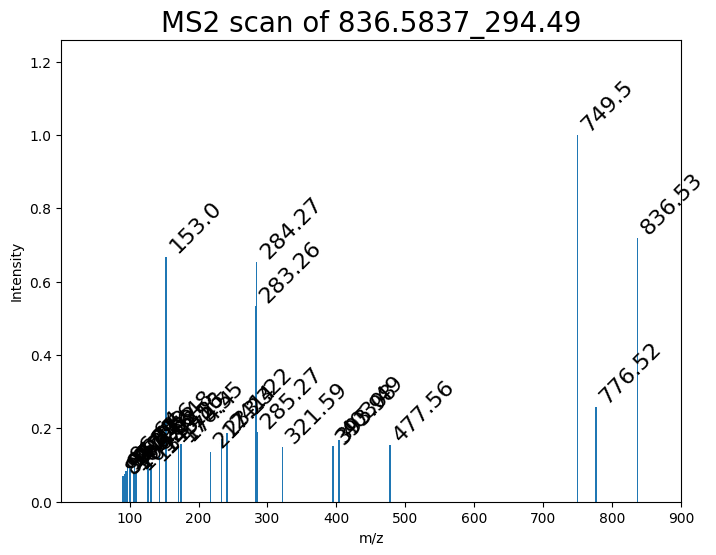

In [11]:
collect_spec = []
ii = 0 
for spec in exp:
    if spec.ms_level == 2: 
        if (2000 < ii < 3500) & (836 < spec.selected_precursors[0]['mz'] < 837):
            print(ii)
            collect_spec.append(spec)
        ii += 1

plot_spectra(collect_spec)

In [12]:
search_NL(collect_spec,
              NL_mz = 87.03124,
              ppm = 100)

10.404624175719269


[<__main__.Spectrum object with native ID 2874 at 0x7fbe0c7f4eb0>]

##### summary
- a probably 12 min run (720 secs) for 4008 scans
- 0.17964 second/scan

## Load target list

In [13]:
import json

In [14]:
with open(annot_dict_input) as f: # 
    annot_dict = json.load(f)

In [15]:
FTIDs = list(annot_dict.keys())

In [16]:
df_feat_annot = pd.read_csv(os.path.join(asari_output_fdr,"Feature_annotation.tsv"),
                           sep = '\t', index_col=0)

In [17]:
## missing the rtime range parameters
df_feat = pd.read_csv(os.path.join(asari_output_fdr,"export/full_Feature_table.tsv"),
                      sep = '\t', index_col=0)

In [18]:
# Select the desired rows and columns from the DataFrame
subset = df_feat_annot.loc[FTIDs, ['mz', 'rtime', 'apex(scan number)']]
# drop duplicates
subset_dd = subset.drop_duplicates() 
# Convert the subset to a dictionary with row-wise orientation
target_dict = subset_dd.to_dict(orient='index')

In [19]:
if 'rtime_left_base' not in list(annot_dict.values())[0]:
    for ftID, v in annot_dict.items():
        row = df_feat.loc[ftID] # get the row
        annot_dict[ftID]['mz'] = row['mz']
        annot_dict[ftID]['rtime'] = row['rtime']
        annot_dict[ftID]['rtime_left_base'] = row['rtime_left_base']
        annot_dict[ftID]['rtime_right_base'] = row['rtime_right_base']
        annot_dict[ftID]['cSelectivity'] = row['cSelectivity']
        annot_dict[ftID]['goodness_fitting'] = row['goodness_fitting']
        annot_dict[ftID]['snr'] = row['snr']

In [20]:
list(annot_dict.items())[0]

('F292',
 {'mz': 490.2552,
  'rtime': 33.72,
  'rtime_left_base': 32.23,
  'rtime_right_base': 35.88,
  'cSelectivity': 1.0,
  'goodness_fitting': 0.94,
  'snr': 1500.0,
  'annotation_evidence': {'in-silico': '1'},
  'name': 'LPS O-17:3',
  'neutral_mass': 491.26480431307,
  'formula': 'C23H42NO8P',
  'formula_dict': {'C': 23, 'H': 42, 'O': 8, 'N': 1, 'P': 1},
  'isomers': [],
  '[M-H+e]': 490.25752786074906})

## Do a pre-filtering, mostly those that fall outside rtime 100-500 seconds, probably won't be PS

In [21]:
target_dict_upd = {}
for k,v in target_dict.items():
    if 100<v['rtime']<500:
        target_dict_upd.update({k:v})

In [22]:
len(target_dict)

1699

In [23]:
len(target_dict_upd)

1421

In [24]:
# testing
target_dict_test = {k:v for k,v in target_dict_upd.items() if k == "F13804"}
target_dict_test

{}

## get potential precursor from multiple files

In [25]:
def get_delta_mz(mz, ppm=20):
    '''
    get delta mz based on ppm
    '''
    delta_mz = round((mz * ppm * 1e-6),4)
    return(delta_mz)

# limit to a retention time window for the spectra

In [26]:
def subset_specs(exp,
                 rt_range):
    rt_scans = [round(spec.scan_time[0]*60,2) for spec in exp]
    ID_lower = next((i for i, x in enumerate(rt_scans) if x >= rt_range[0] ), None)
    ID_upper = next((i for i, x in enumerate(rt_scans) if x >= rt_range[1] ), None)
    sub_exp = []
    for spec in exp:
        if ID_lower < spec.ID < ID_upper:
            sub_exp.append(spec)
    return(sub_exp)

In [27]:
sub_exps = []
for exp in exps: 
    sub_exps.append(subset_specs(exp,rt_range = [200,500]))

[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False


In [28]:
res_dict = {}
ii = 0
for exp in sub_exps:
    for k,v in target_dict_upd.items(): # target_dict_test target_dict_upd
        delta_mz = get_delta_mz(v['mz'],mz_ppm)
        spectra = get_potential_precursor_from_exp_filtbyRt(exp, 
                              min_rt_sec = v['rtime'] - rt_delta, 
                              max_rt_sec = v['rtime'] + rt_delta, 
                              min_mz = v['mz'] - delta_mz,
                              max_mz = v['mz'] + delta_mz, 
                              ms_level=2)
        res_dict[k] = spectra

In [29]:
res_dict_clean = {k:v for k,v in res_dict.items() if len(v) != 0}

In [30]:
parsed_res_dict_clean = {}
for k,v in res_dict_clean.items():
    parsed_res_dict_clean[k] = []
    for spec_obj in v:
        parsed_res_dict_clean[k].append(export_spectrum(spec_obj))

In [31]:
def search_NL_customSpecObj(spectra,
              NL_mz = 87.03124,
              ppm_prec = 100,
              ppm = 40):
    res_data = []

    for spec in spectra:
        in_ms2_precursor = find_in_ms2_precursor(spec,ppm_prec = 100, present = 0.05)
        if np.isnan(in_ms2_precursor):
            sel_prec_mz = spec['precursor_mz'] # this m/z will not be exactly the precursor m/z    
        else:
            sel_prec_mz = in_ms2_precursor
        
        sel_mz = [mz for mz in spec['mzs'] if abs(mz - sel_prec_mz) < (np.ceil(NL_mz)+1)] # +1 is to increase a little bit the range
    
        for mz in sel_mz:
            calc_ppm = cal_ppm((sel_prec_mz - mz),NL_mz)
            if calc_ppm < ppm:
                print(calc_ppm)
                res_data.append(spec)
                break
    return res_data

In [32]:
parsed_NL_res_dict = {}
for FTID, spectra in parsed_res_dict_clean.items():
    parsed_NL_res_dict.update({FTID: search_NL_customSpecObj(spectra)})

0.7645871616580479
0.7645871616580479
4.3469484352417815
3.6258980829381247
16.89901450945355
4.3469484352417815
3.6258980829381247
16.89901450945355
4.3469484352417815
3.6258980829381247
16.89901450945355
4.3469484352417815
3.6258980829381247
16.89901450945355
4.3469484352417815
3.6258980829381247
16.89901450945355
1.478456184772196
7.1521552207592585
4.291517549009056
4.98092516818352
1.478456184772196
7.1521552207592585
4.291517549009056
4.98092516818352
1.478456184772196
7.1521552207592585
4.291517549009056
4.98092516818352
7.1521552207592585
4.291517549009056
4.98092516818352
10.349417706431927
10.349417706431927


In [33]:
parsed_NL_res_dict_clean = {k:v for k,v in parsed_NL_res_dict.items() if len(v) != 0}

In [34]:
with open(f"./data/{output_fdr}/NL_matched_specs.json", "w") as f:
    json.dump(parsed_NL_res_dict_clean, f, indent=2)

## Document annotation in the annotation dict

In [35]:
for k,v in parsed_NL_res_dict_clean.items():
    if "MS2" not in annot_dict[k]['annotation_evidence']:
        annot_dict[k]['annotation_evidence']["MS2"] = []
        
    in_ms2_precursors = [find_in_ms2_precursor(x) for x in v]
    record = {
        'source':exp_label,
        'estimated_time': [x['est_time'] for x in v],
        'precursor': [x['precursor_mz'] for x in v],
        'in-ms2-precursor': in_ms2_precursors,
        'ppm_btw_precur_feat_mz': round(cal_ppm(np.mean([x['precursor_mz'] for x in v]),annot_dict[k]['mz']),2),
        'ppm_btw_in-ms2_precur_feat_mz': round(cal_ppm(np.nanmean(in_ms2_precursors,),annot_dict[k]['mz']),2),
        'parameters':{
            'neutral_loss': 87.03124,
            'ppm_NL':40,
            'rt_window':[-rt_delta,rt_delta],
            'mz_ppm':mz_ppm            }
        }
    if not np.isnan(record['ppm_btw_in-ms2_precur_feat_mz']):
        if record['ppm_btw_in-ms2_precur_feat_mz'] > 20: 
            record = {}
            print(f"exlude {k}/{annot_dict[k]['name']} because out of ppm range to in-ms2 precursor m/z")
    else:
        if record['ppm_btw_precur_feat_mz'] > 20:
            record = {}
            print(f"exlude {k}/{annot_dict[k]['name']} because out of ppm range comparing to precursor m/z")
        
    if record not in annot_dict[k]['annotation_evidence']['MS2']:
        annot_dict[k]['annotation_evidence']['MS2'].append(record)

exlude F12470/LPS 39:4 because out of ppm range to in-ms2 precursor m/z
exlude F12471/LPS 39:4 because out of ppm range to in-ms2 precursor m/z
exlude F12472/LPS 39:4 because out of ppm range to in-ms2 precursor m/z
exlude F12473/LPS 39:4 because out of ppm range to in-ms2 precursor m/z
exlude F15165/LPS 41:6 because out of ppm range to in-ms2 precursor m/z
exlude F15179/LPS O-42:6 because out of ppm range to in-ms2 precursor m/z
exlude F15557/LPS 41:5 because out of ppm range to in-ms2 precursor m/z


In [36]:
with open(f"./data/{output_fdr}/chainable_annotation_{exp_label}.json", "w") as f:
    json.dump(annot_dict, f, indent=2)

# plot accordingly

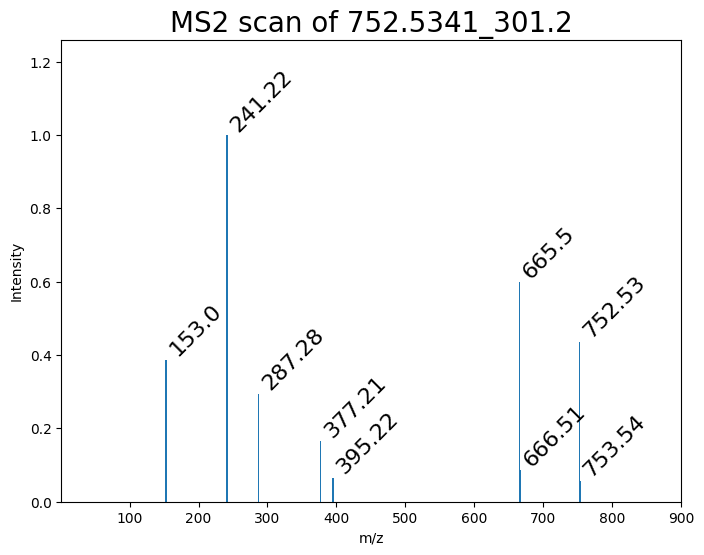

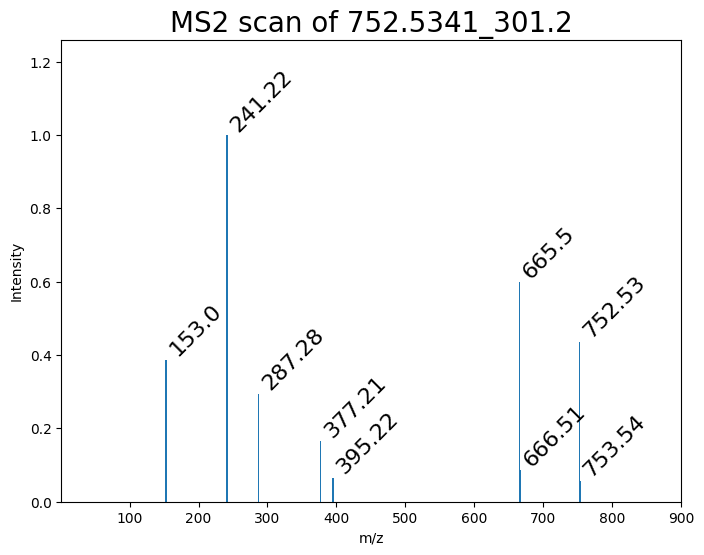

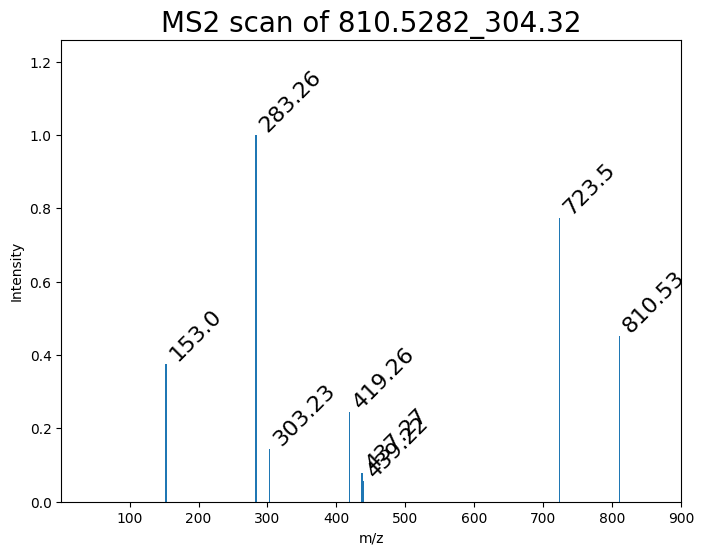

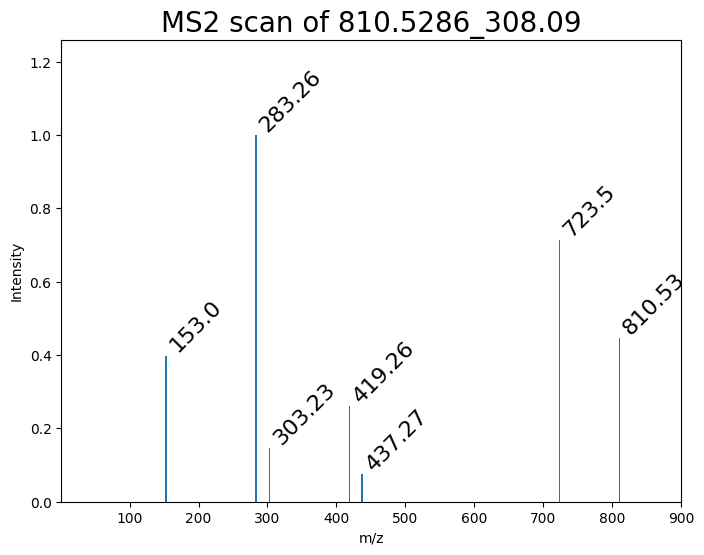

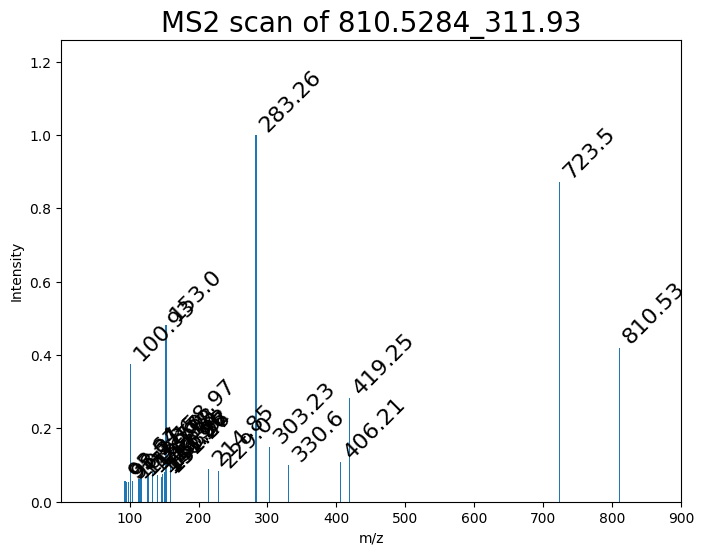

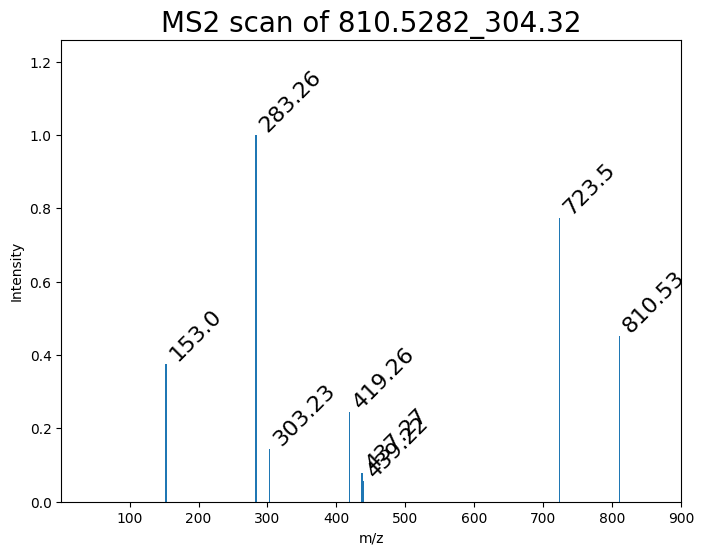

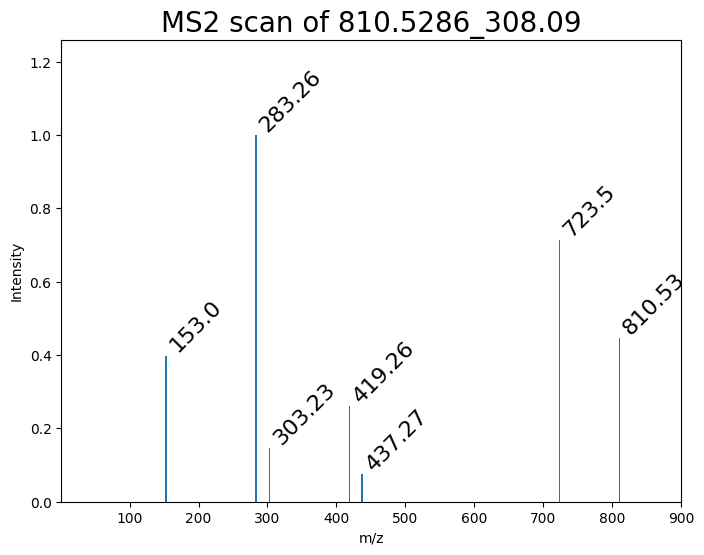

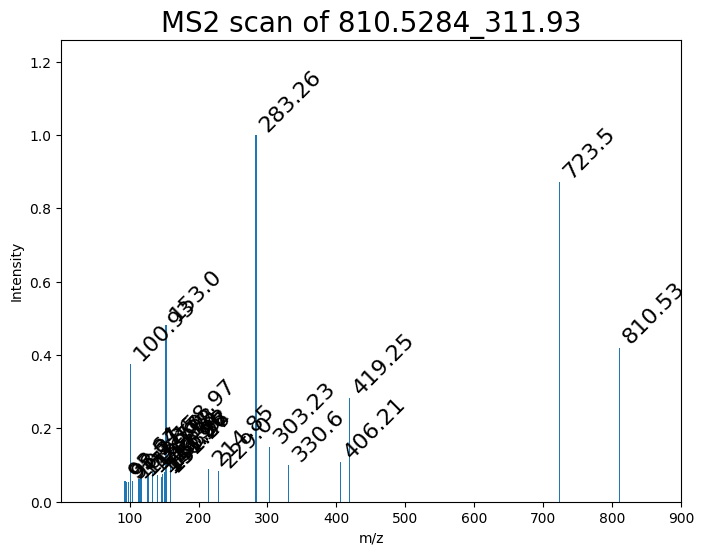

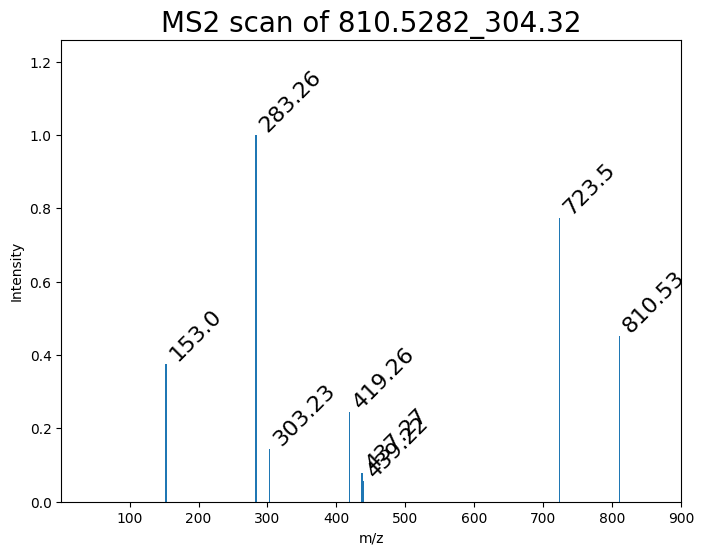

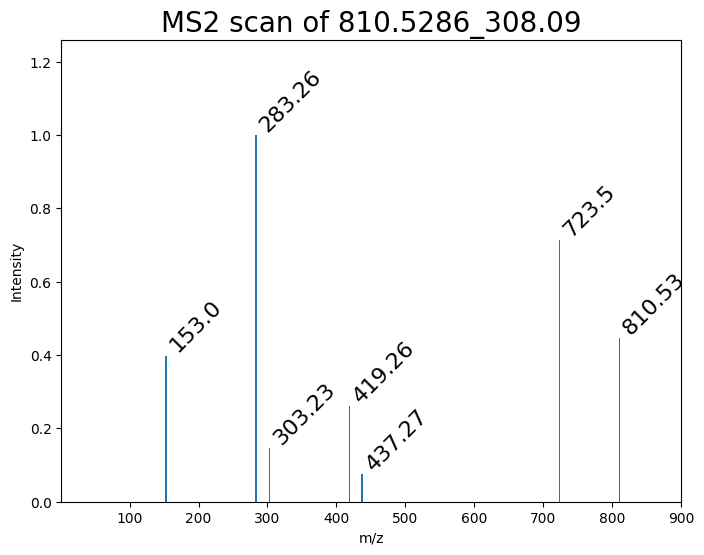

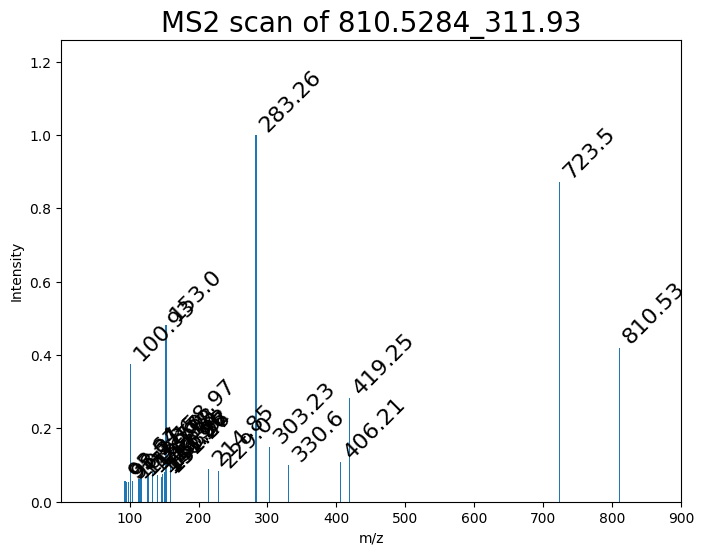

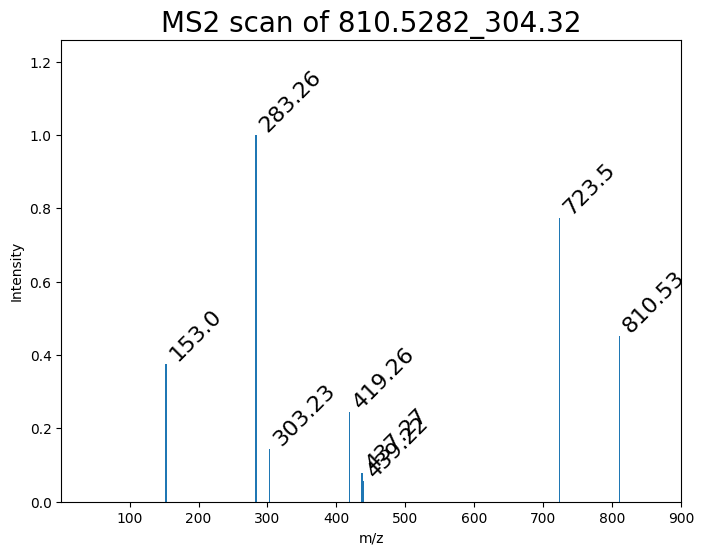

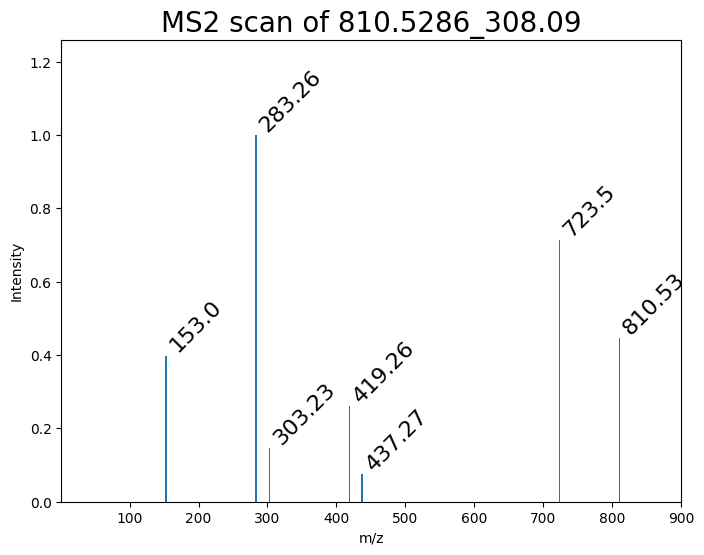

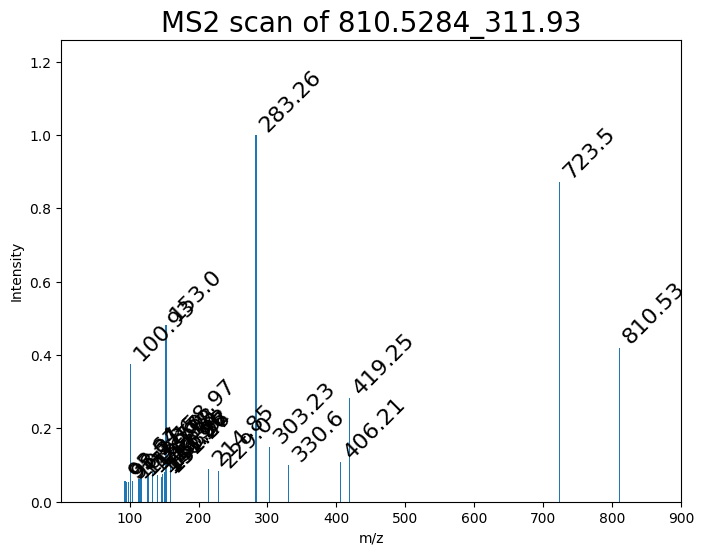

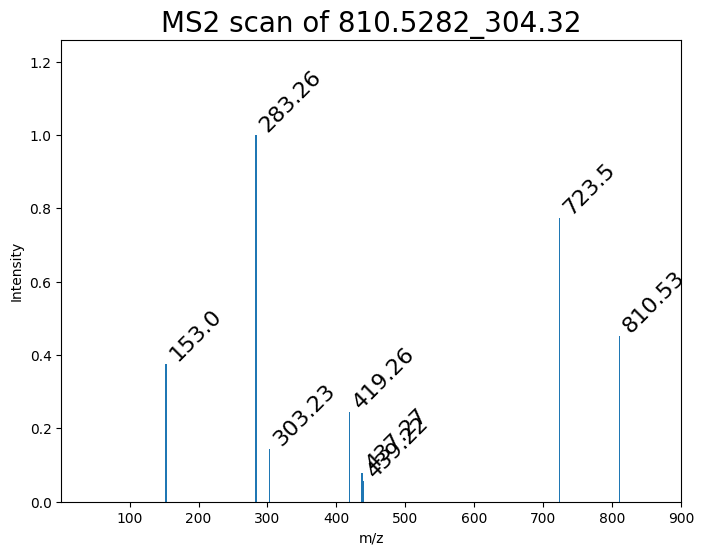

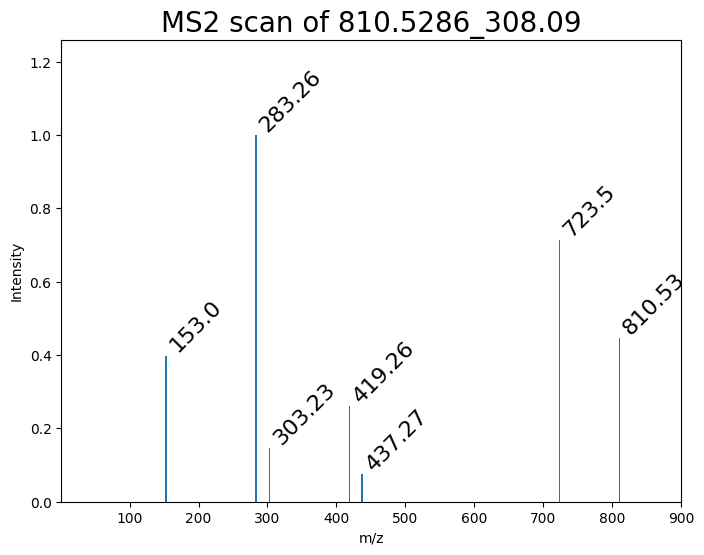

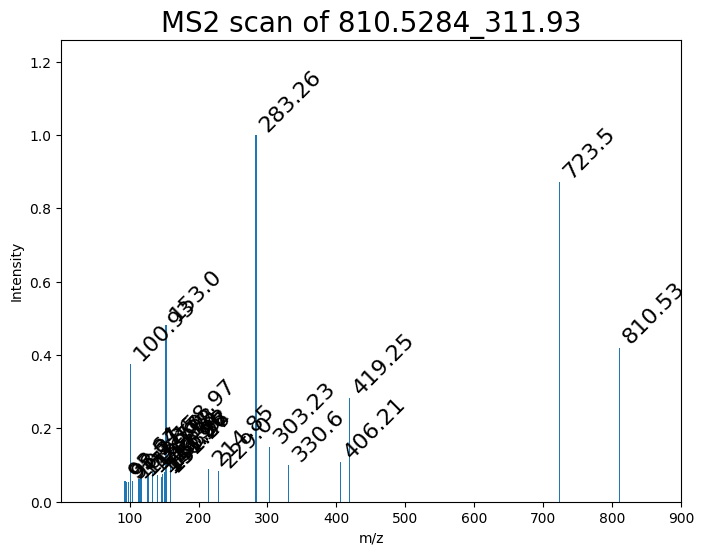

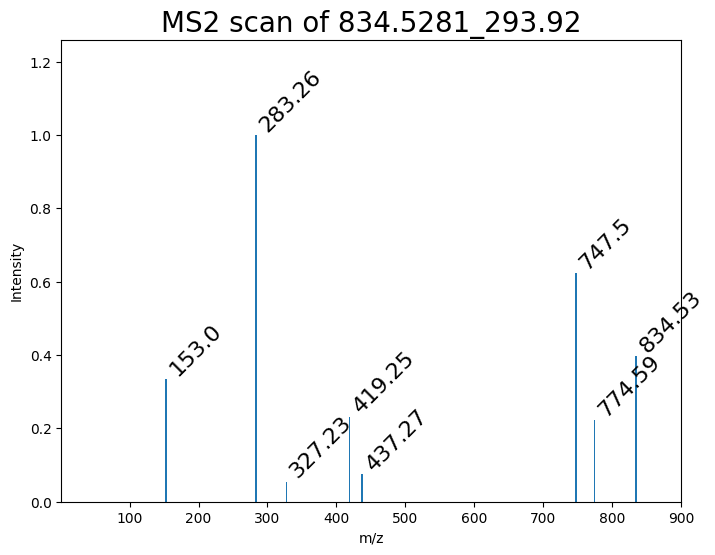

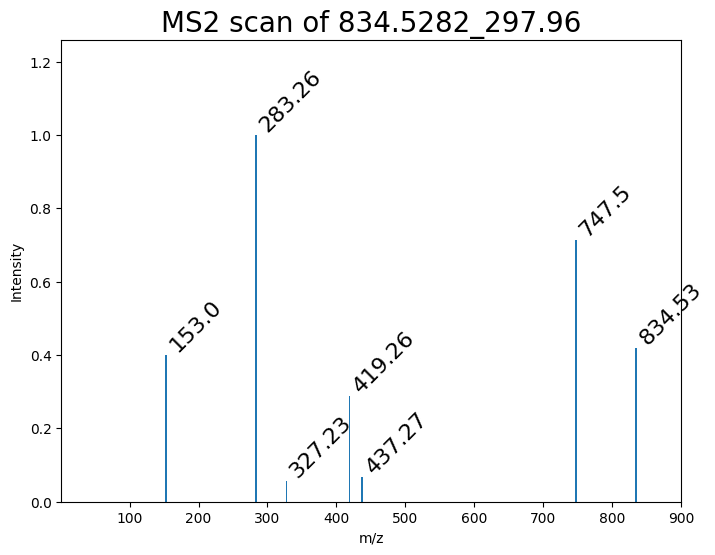

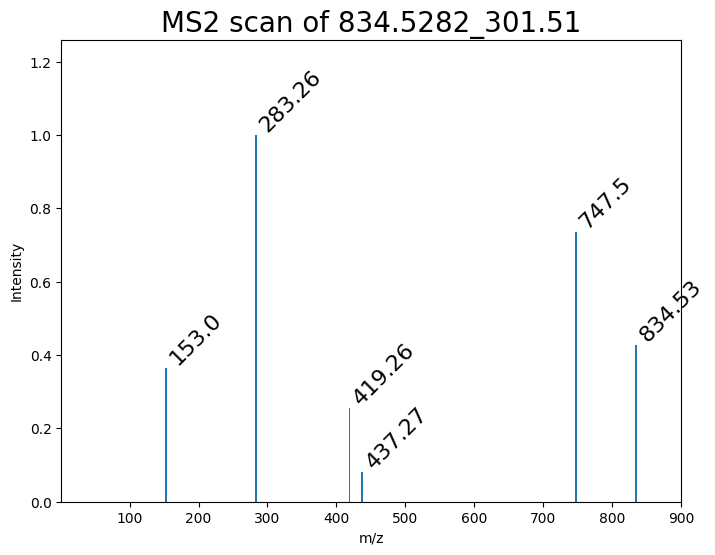

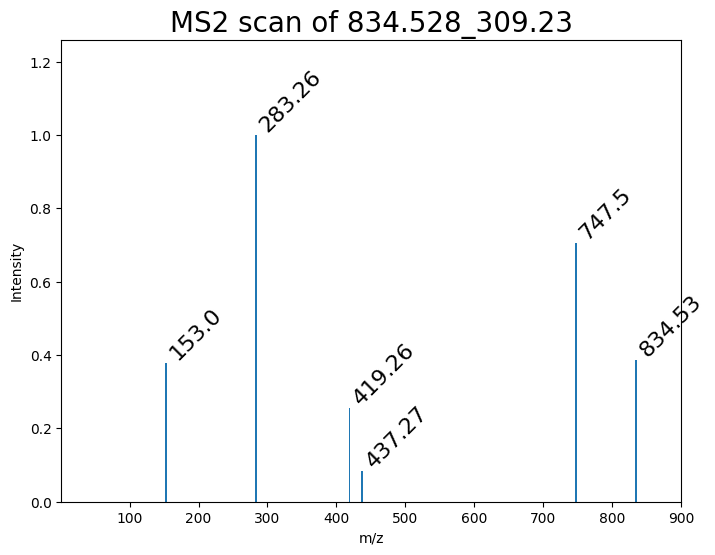

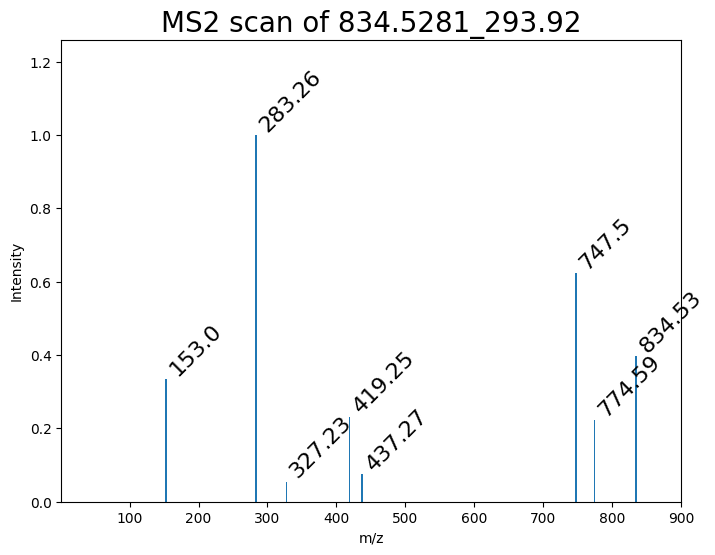

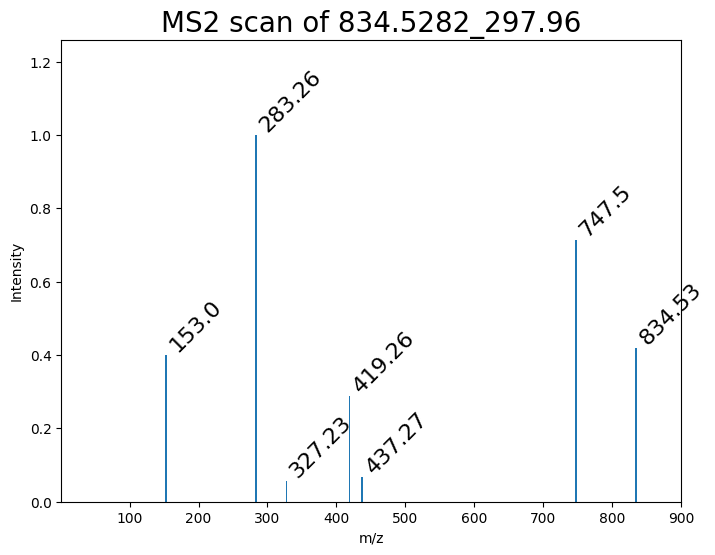

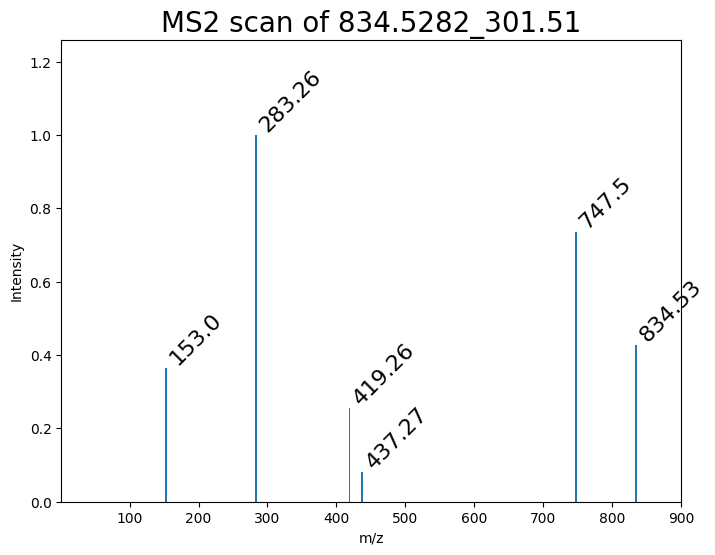

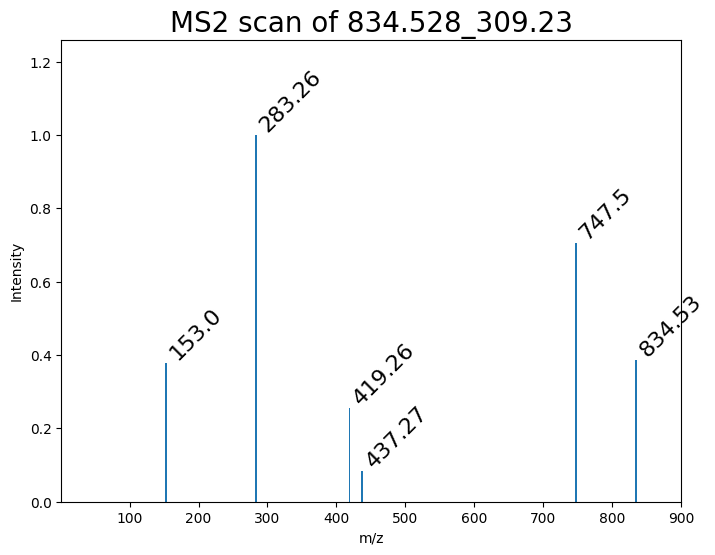

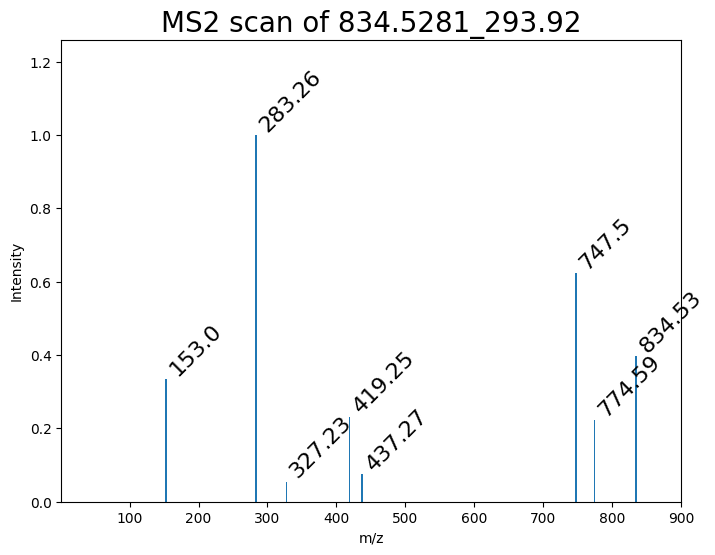

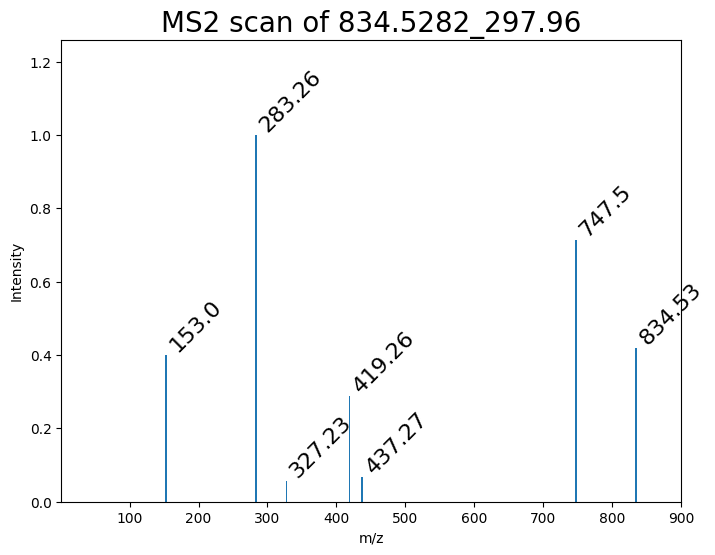

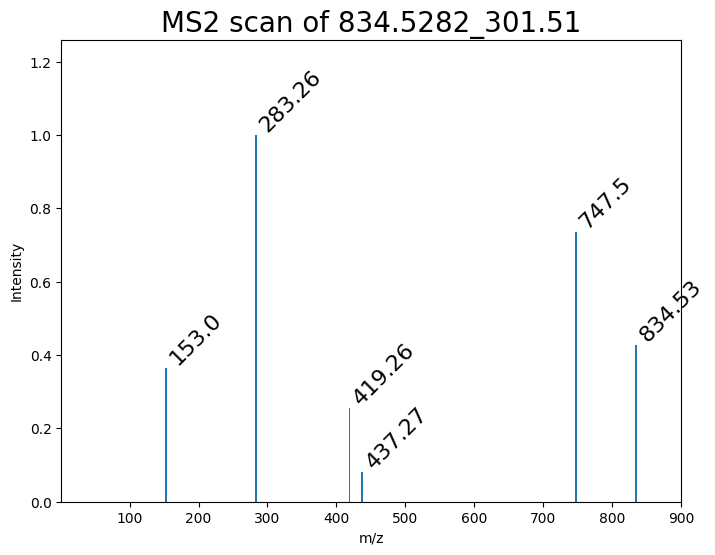

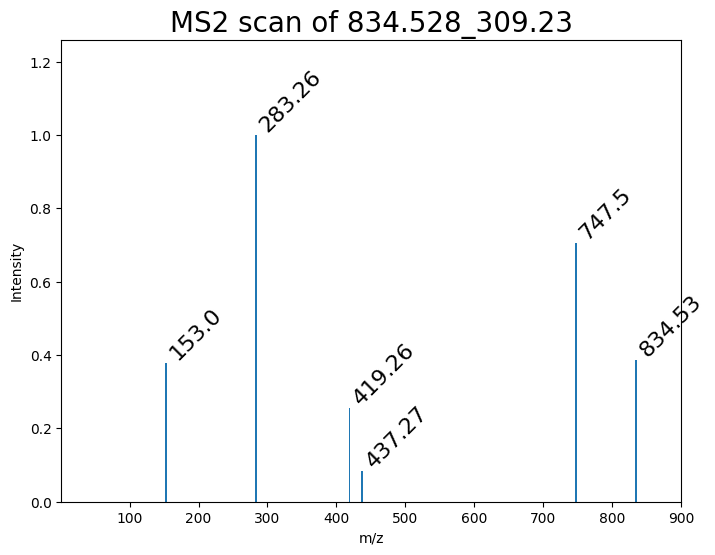

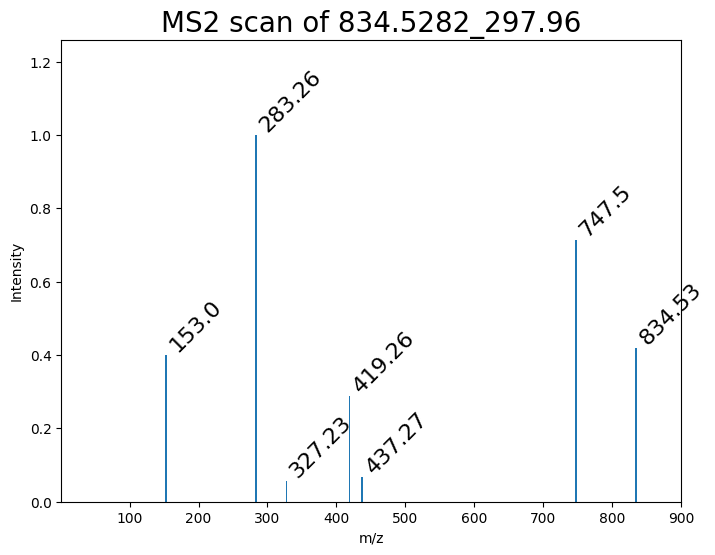

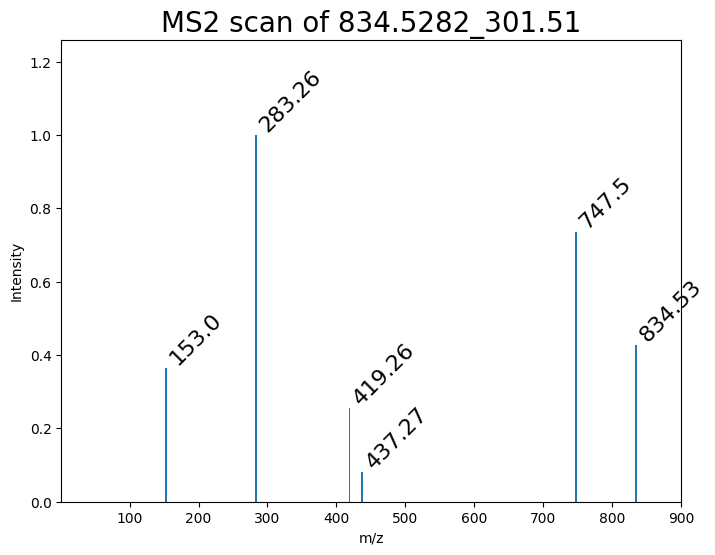

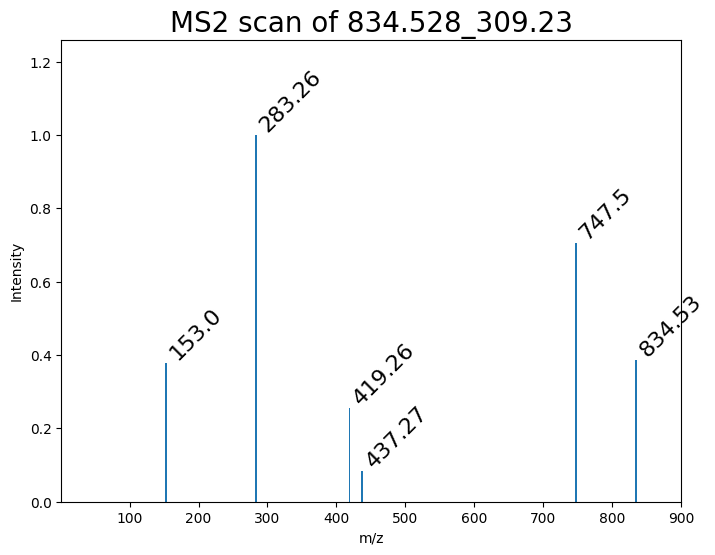

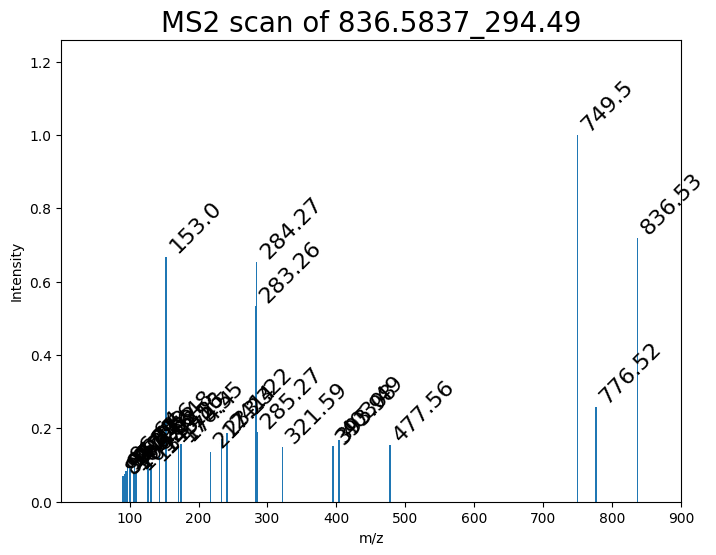

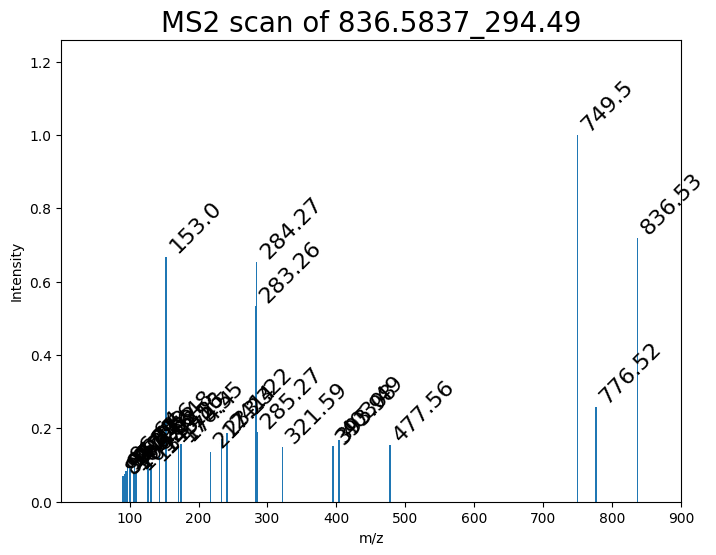

In [37]:
for FTID in parsed_NL_res_dict_clean.keys():
    plot_spectrum_from_list_of_dict(spec_dicts = parsed_NL_res_dict_clean[FTID], 
                 save_figure=True,
                 output_path=f"./data/{output_fdr}/{FTID}_{annot_dict[FTID]['name']}/",
                 label = f"{FTID}_{annot_dict[FTID]['name']}"
                 )